<a id="water_detection_with_wofs_top"></a>
# CEOS Data Cube - Water Detection with WOfS
<hr>

# Notebook Description

This notebook showcases the Australian Water Observations from Space (WOfS) algorithm for water detection on Landsat 7 and Landsat 8 data. You can find more information about WOfS from its origin web service [here](https://www.ga.gov.au/scientific-topics/earth-obs/case-studies/water-observations-from-space#:~:text=Water%20Observations%20from%20Space%20(WOfS,Landsat%208%20satellite%20imagery%20archive.).

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#water_detection_with_wofs_import)
* [Choose Platform and Product](#water_detection_with_wofs_plat_prod)
* [Get the Maximum Extents of the Cube](#water_detection_with_wofs_extents)
* [Define the Extents of the Analysis](#water_detection_with_wofs_define_extents)
* [Load Data from the Data Cube](#water_detection_with_wofs_retrieve_data)
* [Show a Single Acquisition](#water_detection_with_wofs_show_single_acquisition)
* [Perform Timeseries Analysis](#water_detection_with_wofs_timeseries_analysis)

## <span id="water_detection_with_wofs_import">Import Dependencies and Connect to the Data Cube [&#9652;](#water_detection_with_wofs_top)</span>

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

%matplotlib inline

from utils.data_cube_utilities.data_access_api import DataAccessApi

import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import numpy as np
import pandas as pd

import datacube
from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_utilities import perform_timeseries_analysis
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_time import dt_to_str
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
import dc_au_colormaps

import xarray as xr

from dc_notebook_utilities import create_acq_date_gui

In [2]:
from datacube.utils.aws import configure_s3_access
configure_s3_access(requester_pays=True)

api = DataAccessApi()
dc = api.dc

## <span id="water_detection_with_wofs_plat_prod">Choose Platform and Product [&#9652;](#water_detection_with_wofs_top)</span>

In [3]:
# Get available products
products_info = dc.list_products()

In [4]:
# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
4,LANDSAT_7,ls7_usgs_sr_scene


In [5]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
1,LANDSAT_8,ls8_usgs_sr_scene


In [6]:
platforms = ['LANDSAT_7', 'LANDSAT_8']
products = ['ls7_usgs_sr_scene', 'ls8_usgs_sr_scene']
collections = ['c1', 'c1']
levels = ['l2', 'l2']

## <span id="water_detection_with_wofs_extents">Get the Maximum Extents of the Cube [&#9652;](#water_detection_with_wofs_top)</span>

**With the platform and product, we can get the rest of the metadata.** This includes the resolution of a pixel, the latitude/longitude extents, and the minimum and maximum dates available of the chosen platform/product combination.

In [7]:
full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

In [8]:
print("Available Latitude Extents:", full_lat)
print("Available Longitude Extents:", full_lon)
print("Available Time Extents:", np.vectorize(dt_to_str)(min_max_dates))

Available Latitude Extents: (-12.524861111211308, 12.623472222323212)
Available Longitude Extents: (-14.64125000011713, 44.00986111146319)
Available Time Extents: [['2000-01-01' '2020-01-10']
 ['2013-03-21' '2020-01-27']]


In [9]:
display_map(latitude=full_lat, longitude=full_lon)

## <span id="water_detection_with_wofs_define_extents">Define the Extents of the Analysis [&#9652;](#water_detection_with_wofs_top)</span>

In [10]:
start_dates = ["2004-01-01", "2017-01-01"]
end_dates = ["2004-01-31", "2017-12-31"]

# Weija Reservoir, Ghana
lon_small = (-0.410, -0.330)
lat_small = (5.545, 5.620)

# Part of Lake Volta
# lon_small = (-0.0847, -0.0545)
# lat_small = (6.7616, 6.8312)

display_map(lat_small, lon_small)

## <span id="water_detection_with_wofs_retrieve_data">Load Data from the Data Cube [&#9652;](#water_detection_with_wofs_top)</span>

**At this point, we must access our data cube and analyze our data.** In this example, we will run the WOFS algorithm. The **wofs_classify** function, seen below, will return a modified dataset, where a value of 1 indicates the pixel has been classified as water by the WoFS algorithm and 0 represents the pixel is non-water.

*****

For more information on the WOFS algorithm, refer to:

Mueller, et al. (2015) "Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia." *Remote Sensing of Environment*.

In [11]:
wofs_classifications = []
measurements = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']

for i, (product,platform,collection,level) in \
        enumerate(zip(products, platforms, collections, levels)):
    start_date = start_dates[i]
    end_date = end_dates[i]
    # Query the Data Cube
    dataset_in = dc.load(platform  = platform,
                         product   = product,
                         time      = (start_date, end_date),
                         lon       = lon_small, 
                         lat       = lat_small,
                         measurements=measurements,
                         dask_chunks={'time':1, 'latitude':1000, 'longitude':1000}).persist()
    if len(dataset_in.dims) == 0: # The dataset is empty.
        continue
    # WOFS classification
    clean_mask = landsat_qa_clean_mask(dataset_in, platform=platform, 
                                       collection=collection, level=level)
    water_class = wofs_classify(dataset_in, clean_mask=clean_mask.values).persist()
    wofs_classifications.append(water_class)#.copy(deep=True))
complete_dataset = None
if len(wofs_classifications) != 0:
    complete_dataset = xr.concat(wofs_classifications, 'time')
else:
    complete_dataset = xr.Dataset()

## <span id="water_detection_with_wofs_show_single_acquisition">Show a Single Acquisition [&#9652;](#water_detection_with_wofs_top)</span>

**Execute the following code and then use the generated form to choose your desired acquisition date.**

In [12]:
acq_dates = list(complete_dataset.time.values.astype(str))
acq_dates = list(map(lambda x:x.split("T")[0],acq_dates))
acq_date_input = create_acq_date_gui(acq_dates)

Label(value='Acquisition Date: ')

Dropdown(options=('2017-01-09', '2017-01-25', '2017-02-10', '2017-02-26', '2017-03-14', '2017-03-30', '2017-04…

In [13]:
# Save form value
acq_date = acq_date_input.value
acq_date_index = acq_dates.index(acq_date)

# Get water class for selected acquisition date and mask no data values
water_class_for_acq_date = complete_dataset.wofs[acq_date_index]
water_class_for_acq_date.values = water_class_for_acq_date.values.astype('float')
water_class_for_acq_date.values[water_class_for_acq_date.values == -9999] = np.nan

if len(water_class_for_acq_date.values[water_class_for_acq_date.values > -9999]) > 0:
    water_class_for_acq_date.plot(cmap='BuPu')
    plt.title(pd.to_datetime(water_class_for_acq_date.time.values).strftime('%Y-%m-%d') + " (YYYY-MM-DD)")

## <span id="water_detection_with_wofs_timeseries_analysis">Perform Timeseries Analysis [&#9652;](#water_detection_with_wofs_top)</span>

**With all of the pixels classified as either water/non-water, let's perform a time series analysis over our derived water class.** The function, **perform_timeseries_analysis**, takes in a dataset of 3 dimensions (time, latitude, and longitude), then sums the values of each pixel over time (# water). It also keeps track of the number of clear observations we have at each pixel (#clear). We can then normalize each pixel to determine areas at risk of flooding. The normalization calculation is simply:

$$normalized\_water\_observations = \dfrac{total\_water\_observations}{total\_clear\_observations}$$.

The output each of the three calculations (# water, # clear, "normalized water" - or "% water") can be seen below.

In [14]:
time_series = perform_timeseries_analysis(water_class, 'wofs')
time_series

<xarray.Dataset>
Dimensions:          (latitude: 270, longitude: 288)
Coordinates:
  * latitude         (latitude) float64 5.62 5.62 5.619 ... 5.546 5.545 5.545
  * longitude        (longitude) float64 -0.4099 -0.4096 ... -0.3304 -0.3301
    spatial_ref      int32 4326
Data variables:
    normalized_data  (latitude, longitude) float64 dask.array<chunksize=(270, 288), meta=np.ndarray>
    min              (latitude, longitude) float64 dask.array<chunksize=(270, 288), meta=np.ndarray>
    max              (latitude, longitude) float64 dask.array<chunksize=(270, 288), meta=np.ndarray>
    total_data       (latitude, longitude) float64 dask.array<chunksize=(270, 288), meta=np.ndarray>
    total_clean      (latitude, longitude) int64 dask.array<chunksize=(270, 288), meta=np.ndarray>

**Show the normalized water frequency according to WOfS.**

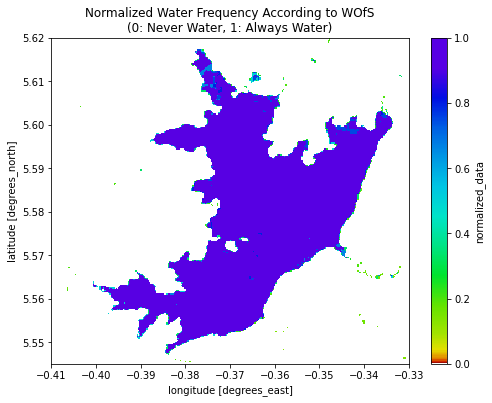

In [15]:
plt.figure(figsize=(8,6))
time_series.normalized_data.plot(cmap='dc_au_WaterSummary')
plt.title('Normalized Water Frequency According to WOfS\n(0: Never Water, 1: Always Water)')
plt.show()

**Show the total clear water times according to WOfS.**

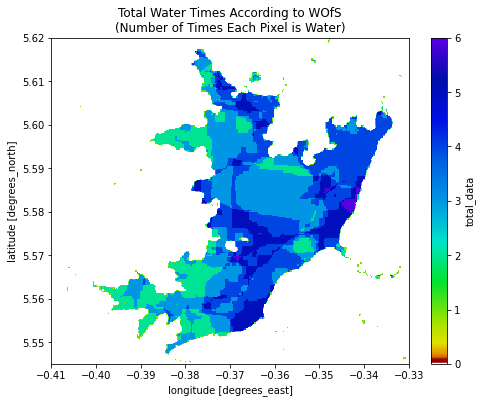

In [16]:
plt.figure(figsize=(8,6))
time_series.total_data.plot(cmap='dc_au_WaterObservations')
plt.title('Total Water Times According to WOfS\n(Number of Times Each Pixel is Water)')
plt.show()

**Show the total clear times.**

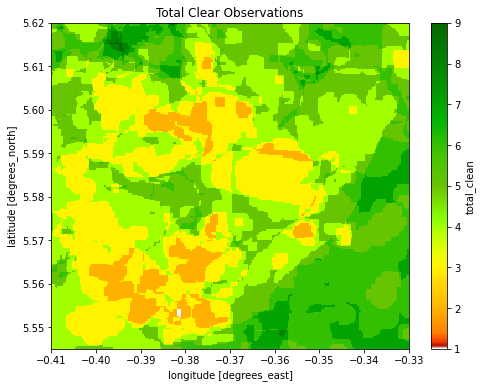

In [17]:
plt.figure(figsize=(8,6))
time_series.total_clean.plot(cmap='dc_au_ClearObservations')
plt.title('Total Clear Observations')
plt.show()